In [1]:
### Merge airsea 1-min files: directly from Mule
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import cftime
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)

In [2]:
path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_2023/delayed_post_mission/sd-1031/'
test = os.listdir(path)
print(len(test))

1008


In [3]:
year = '2023'
platf_num = '1031'
### folder name that hosts the airsea data
# for importing saildrone data from mule: make sure it is mounted (mule.pmel.noaa.gov)
if year == '2021':
    sd_year = ['1031','1040','1045','1048','1060']
    path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_2021_updated/daily_files/'+platf_num+'/'
elif year == '2022':
    sd_year = ['1031','1032','1040','1059','1078','1083','1084']
    path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_2022/delayed/'+platf_num+'/'
elif year == '2023':
    sd_year = ['1031','1036','1040','1041','1042','1045','1057','1064','1065','1068','1069','1083']
    # path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_2023/delayed/'+platf_num+'/'
    path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_2023/delayed_post_mission/sd-'+platf_num+'/'
elif year == '2024':
    sd_year = ['1030','1031','1036','1040','1041','1042','1045','1057','1068','1069','1083','1091']
    path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/noaa_hurricane_2024/delayed/'+platf_num+'/'

In [4]:
filenames_all = np.sort( os.listdir(path) )
print('Number of Files in for this directory on Mule:',len(filenames_all))
pathout = os.getcwd()+'/fig_merge_raw_airsea/'
if os.path.isdir(pathout):
    pass
else:
    os.mkdir(pathout)
### retain the filenames wanted only
filenames = np.array([])
for file in filenames_all:
    if ('saildrone' in file) & ('.nc' in file):
        filenames = np.append(filenames, file)
print('Files have "saildrone" & ".nc" in the sub-directory on Mule:',len(filenames))
print(filenames)
### the list of variables I want
vars_yes = ['latitude','longitude','time','UWND_MEAN','UWND_STDDEV','VWND_MEAN','VWND_STDDEV','GUST_WND_MEAN','GUST_WND_STDDEV',\
            'WIND_MEASUREMENT_HEIGHT_MEAN','TEMP_AIR_MEAN','RH_MEAN','BARO_PRES_MEAN','PAR_AIR_MEAN',\
                'WAVE_DOMINANT_PERIOD','WAVE_SIGNIFICANT_HEIGHT',\
                    'TEMP_DEPTH_HALFMETER_MEAN','TEMP_SBE37_MEAN','TEMP_SBE37_STDDEV','SAL_SBE37_MEAN','SAL_SBE37_STDDEV',\
                        'WATER_CURRENT_SPEED_MEAN','WATER_CURRENT_DIRECTION_MEAN']

Number of Files in for this directory on Mule: 1008
Files have "saildrone" & ".nc" in the sub-directory on Mule: 1008
['saildrone-gen_6-hurricane_monitoring_2023-sd1031-20230801T000000-20230801T015959-1_minutes-v1.1702933963642.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1031-20230801T020000-20230801T035959-1_minutes-v1.1702933964642.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1031-20230801T040000-20230801T055959-1_minutes-v1.1702933965431.nc'
 ...
 'saildrone-gen_6-hurricane_monitoring_2023-sd1031-20231023T180000-20231023T195959-1_minutes-v1.1702934842406.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1031-20231023T200000-20231023T215959-1_minutes-v1.1702934843484.nc'
 'saildrone-gen_6-hurricane_monitoring_2023-sd1031-20231023T220000-20231023T235959-1_minutes-v1.1702934844213.nc']


In [14]:
### try open the nc files and see how many can be opened
print('check numbers of files can be open or not.')
numOK = 0
numBAD = 0
filenames_canopen = []
f_print = np.arange(0,len(filenames),int(len(filenames)/20))
for f in range( len(filenames) ):
    try: # block raising an exception
        ds = nc.Dataset(path+filenames[f])
        test = ds.variables['time'][:]
        ds.close()
        numOK = numOK + 1
        filenames_canopen.append(filenames[f])
        # print('Done',filenames[f])
    except: # doing nothing on exception
        numBAD = numBAD + 1
        # print('cannot open file:',filenames[f])
        pass
    if f in f_print:
        print(f/len(filenames),'%','of files is done.')
print(numOK,'can be open.')
print(numBAD,'cannot be open.')

check numbers of files can be open or not.
0.0
0.0496031746031746
0.0992063492063492
0.1488095238095238
0.1984126984126984
0.24801587301587302
0.2976190476190476
0.3472222222222222
0.3968253968253968
0.44642857142857145
0.49603174603174605
0.5456349206349206
0.5952380952380952
0.6448412698412699


In [14]:
### create a dictionary
vars_dic = {}
vars_dic_attr = {}
attr = ['long_name','units','installed_height']
vars_no_installed_height = ['latitude','longitude','time']
ds = nc.Dataset(path+'/'+filenames_canopen[0])
# nz = len( ds.variables['cell_depth'][:] )
varnms = list( ds.variables.keys() )
### add empty items to the dictionary 
for i in range( len(varnms) ):
    vkey = varnms[i]
    if vkey in vars_yes:
        item = ds.variables[vkey][:]
        vars_dic[vkey] = np.empty( item.shape )
        attr_in_vkey = ds.variables[vkey].ncattrs()
        ### record attributes
        for a in range( len(attr) ):
            if attr[a] in attr_in_vkey: # if attribute of this vkey exist, write out
                if (attr[a] == 'installed_height') & (vkey in vars_no_installed_height):
                    pass
                else:
                    str_eval = "ds.variables['" + vkey + "']." + attr[a]
                    vars_dic_attr[vkey+'-'+attr[a]] = eval(str_eval)
        # print(vkey, item.shape, vars_dic[vkey].shape)
print(len(varnms),'variables in nc file &', len(vars_dic),'variables are selected to append')
### go through each daily nc file & append the selected variables 
vars_exists = []
for f in range( len(filenames_canopen) ):
    fsize = os.stat(path+'/'+filenames_canopen[f]).st_size/1000 # kb
    if fsize > 0:#400:
        ds = nc.Dataset(path+'/'+filenames_canopen[f])
        for i in range( len(varnms) ):
            vkey = varnms[i]
            if (vkey in vars_yes): #& (vkey not in vars_nostack):
                # print(vkey)
                vars_exists.append(vkey)
                vkey = varnms[i]
                item_old = vars_dic[vkey]
                item_app = np.squeeze( ds.variables[vkey][:] )
                ### append in time dimension only
                if f == 0:
                    vars_dic[vkey] = item_app
                else:
                    vars_dic[vkey] = np.concatenate( (item_old, item_app),axis=0 )
        print('Done',filenames_canopen[f])
    else:
        print(filenames_canopen[f],'filesize too small. skipped')

77 variables in nc file & 23 variables are selected to append
Done saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231017T220000-20231017T235959-1_minutes-v1.1698694836750.nc
Done saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231018T000000-20231018T015959-1_minutes-v1.1698694837678.nc
Done saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231018T020000-20231018T035959-1_minutes-v1.1698694838813.nc
Done saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231018T040000-20231018T055959-1_minutes-v1.1698694839802.nc
Done saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231018T060000-20231018T075959-1_minutes-v1.1698694840686.nc
Done saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231018T080000-20231018T095959-1_minutes-v1.1698694841478.nc
Done saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231018T100000-20231018T115959-1_minutes-v1.1698694842264.nc
Done saildrone-gen_6-hurricane_monitoring_2023-sd1042-20231018T120000-20231018T135959-1_minutes-v1.1698694843588.nc
Done saild

In [15]:
print(ds.variables['time'].ncattrs())

['_FillValue', 'units', 'calendar']


min time difference= 60.0 sec
1st & last time in file: 10/17 22:00Z 11/15 19:59Z
2 time gaps that are > 30 min
The corresponding time gaps (in mins) [121. 241.]
11/01 17:59Z - 11/01 20:00Z
11/04 17:59Z - 11/04 22:00Z


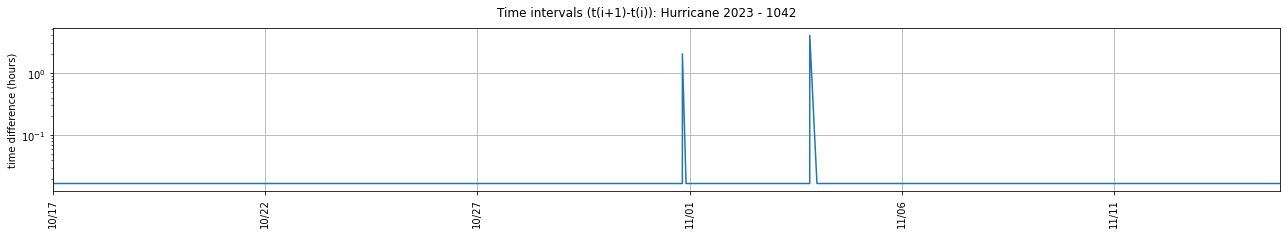

In [16]:
### plot time intervals (time(i+1)-time(i)) and print time gaps
fig, axes = plt.subplots(1)
fig.set_size_inches(22,3)
test = vars_dic['time']
dtime = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds= vars_dic['time'][i]) for i in range(len(vars_dic['time']))])
dtest = np.array([(test[i+1]-test[i])/3600 for i in range( len(test)-1 )]) # 
plt.semilogy(dtime[:-1],dtest)
ddays = (np.max(dtime)-np.min(dtime)).days
xticks = [np.min(dtime)+datetime.timedelta(days=5*i) for i in range(ddays)]
xtickslabel = [xticks[i].strftime('%m/%d') for i in range(ddays)]
plt.xticks(xticks)
plt.gca().set_xticklabels(xtickslabel, rotation=90)
plt.ylabel('time difference (hours)')
plt.xlim([dtime[0],dtime[-1]])
plt.grid()
print('min time difference=',np.min(dtest)*3600,'sec')
print('1st & last time in file:',dtime[0].strftime('%m/%d %H:%MZ'),dtime[-1].strftime('%m/%d %H:%MZ'))
### find data gaps
d5min = (datetime.datetime(2019,1,1,0,5,0)-datetime.datetime(2019,1,1)).total_seconds()/3600
d10min = (datetime.datetime(2019,1,1,0,10,0)-datetime.datetime(2019,1,1)).total_seconds()/3600
d30min = (datetime.datetime(2019,1,1,0,30,0)-datetime.datetime(2019,1,1)).total_seconds()/3600
d60min = (datetime.datetime(2019,1,1,1,0,0)-datetime.datetime(2019,1,1)).total_seconds()/3600
i_tgap = np.where( dtest > d30min )[0]
print(len(i_tgap),'time gaps that are > 30 min')
print('The corresponding time gaps (in mins)',dtest[i_tgap]*60)
for i in range( len(i_tgap) ):
    print(dtime[i_tgap[i]].strftime('%m/%d %H:%MZ'),'-',dtime[i_tgap[i]+1].strftime('%m/%d %H:%MZ'))

plt.suptitle('Time intervals (t(i+1)-t(i)): Hurricane '+year+' - '+platf_num)
### save figure
fig.savefig(pathout+'time_intervals_'+year+'-'+platf_num+'.png', dpi=300,bbox_inches='tight')

['time', 'UWND_MEAN', 'UWND_STDDEV', 'VWND_MEAN', 'VWND_STDDEV', 'GUST_WND_MEAN', 'GUST_WND_STDDEV', 'WIND_MEASUREMENT_HEIGHT_MEAN', 'TEMP_AIR_MEAN', 'RH_MEAN', 'BARO_PRES_MEAN', 'PAR_AIR_MEAN', 'WAVE_DOMINANT_PERIOD', 'WAVE_SIGNIFICANT_HEIGHT', 'TEMP_DEPTH_HALFMETER_MEAN', 'TEMP_SBE37_MEAN', 'TEMP_SBE37_STDDEV', 'SAL_SBE37_MEAN', 'SAL_SBE37_STDDEV', 'WATER_CURRENT_SPEED_MEAN', 'WATER_CURRENT_DIRECTION_MEAN', 'latitude', 'longitude']
dict_keys(['time', 'UWND_MEAN', 'UWND_STDDEV', 'VWND_MEAN', 'VWND_STDDEV', 'GUST_WND_MEAN', 'GUST_WND_STDDEV', 'WIND_MEASUREMENT_HEIGHT_MEAN', 'TEMP_AIR_MEAN', 'RH_MEAN', 'BARO_PRES_MEAN', 'PAR_AIR_MEAN', 'WAVE_DOMINANT_PERIOD', 'WAVE_SIGNIFICANT_HEIGHT', 'TEMP_DEPTH_HALFMETER_MEAN', 'TEMP_SBE37_MEAN', 'TEMP_SBE37_STDDEV', 'SAL_SBE37_MEAN', 'SAL_SBE37_STDDEV', 'WATER_CURRENT_SPEED_MEAN', 'WATER_CURRENT_DIRECTION_MEAN', 'latitude', 'longitude'])
latitude
longitude


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_6687/3208981892.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(h,labels=[vkey],loc='upper left')


UWND_MEAN
UWND_STDDEV
VWND_MEAN
VWND_STDDEV
GUST_WND_MEAN
GUST_WND_STDDEV
WIND_MEASUREMENT_HEIGHT_MEAN


<Figure size 432x288 with 0 Axes>

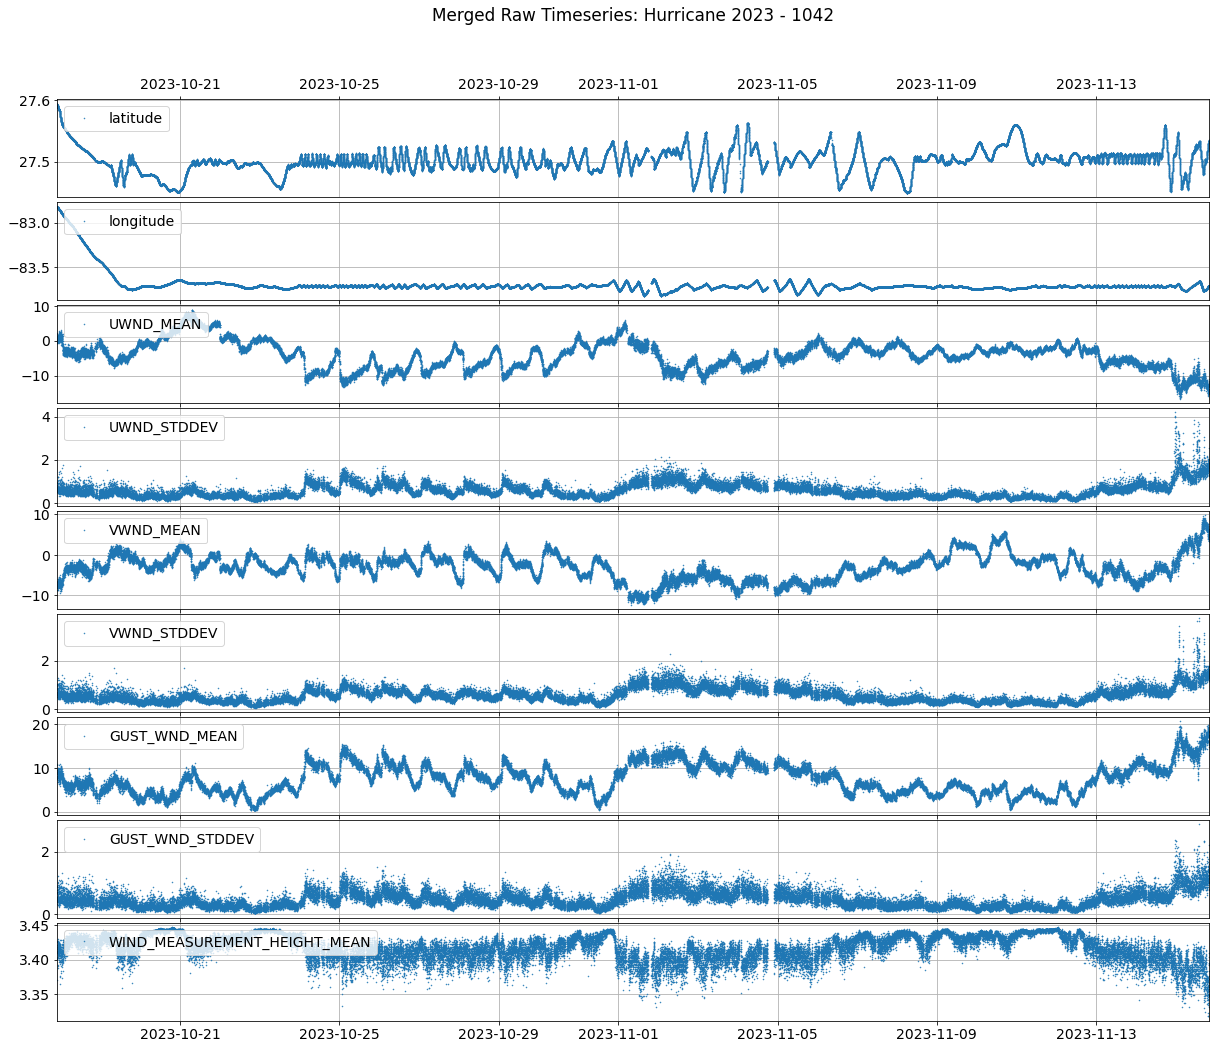

In [18]:
### plot merged raw wind data (1D data)
print(list(vars_dic.keys()))
vars_plot = ['latitude','longitude','UWND_MEAN','UWND_STDDEV','VWND_MEAN','VWND_STDDEV','GUST_WND_MEAN','GUST_WND_STDDEV','WIND_MEASUREMENT_HEIGHT_MEAN']
nrow = len(vars_plot)
tlim = [dtime[0],dtime[-1]]
print(vars_dic.keys())
### initiate plot
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(20,16)
for i in range( nrow ):
    vkey = vars_plot[i]
    if vkey in vars_dic.keys():
        print(vkey)
        data = vars_dic[vkey]
        h = plt.subplot(nrow,1,i+1)
        plt.plot(dtime,data,'.',ms=1)
        plt.xlim(tlim)
        plt.grid()
        plt.legend(h,labels=[vkey],loc='upper left')
        if i == 0:
            plt.gca().xaxis.set_ticks_position('top')
        elif i < nrow-1:
            plt.gca().set_xticklabels('')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
plt.suptitle('Merged Raw Timeseries: Hurricane '+year+' - '+platf_num)
fig.savefig(pathout+'merge_raw_wind_1D_'+year+'-'+platf_num+'.png', dpi=300,bbox_inches='tight')

['time', 'UWND_MEAN', 'UWND_STDDEV', 'VWND_MEAN', 'VWND_STDDEV', 'GUST_WND_MEAN', 'GUST_WND_STDDEV', 'WIND_MEASUREMENT_HEIGHT_MEAN', 'TEMP_AIR_MEAN', 'RH_MEAN', 'BARO_PRES_MEAN', 'PAR_AIR_MEAN', 'WAVE_DOMINANT_PERIOD', 'WAVE_SIGNIFICANT_HEIGHT', 'TEMP_DEPTH_HALFMETER_MEAN', 'TEMP_SBE37_MEAN', 'TEMP_SBE37_STDDEV', 'SAL_SBE37_MEAN', 'SAL_SBE37_STDDEV', 'WATER_CURRENT_SPEED_MEAN', 'WATER_CURRENT_DIRECTION_MEAN', 'latitude', 'longitude']
TEMP_AIR_MEAN
RH_MEAN
BARO_PRES_MEAN


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_6687/687430083.py:22: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(h,labels=[vkey],loc='upper left')


PAR_AIR_MEAN
WAVE_DOMINANT_PERIOD
WAVE_SIGNIFICANT_HEIGHT


<Figure size 432x288 with 0 Axes>

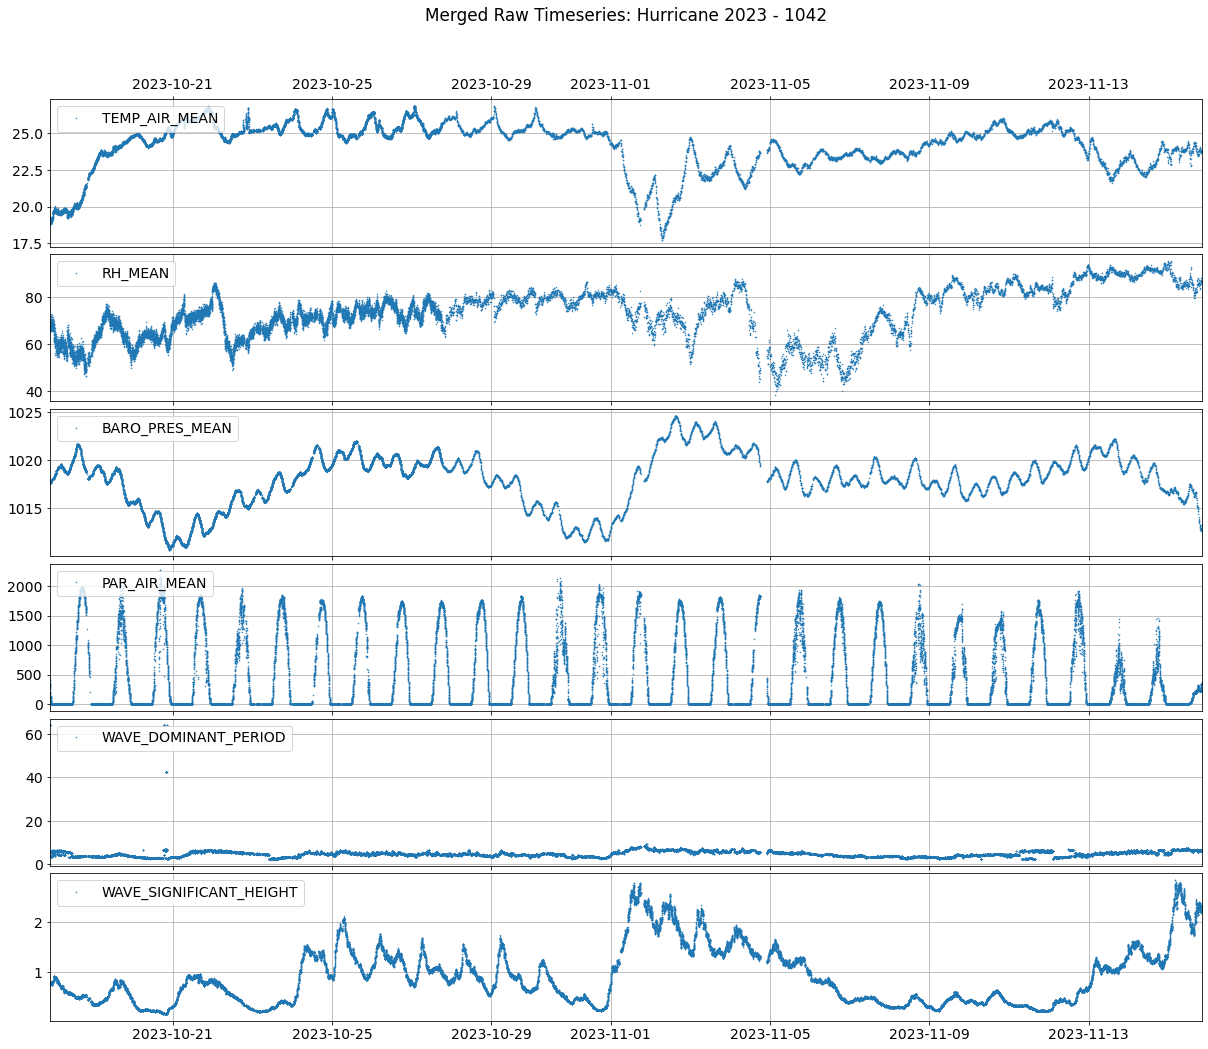

In [19]:
### plot merged raw met data (1D data)
print(list(vars_dic.keys()))
vars_plot = ['TEMP_AIR_MEAN','RH_MEAN','BARO_PRES_MEAN','PAR_AIR_MEAN','WAVE_DOMINANT_PERIOD','WAVE_SIGNIFICANT_HEIGHT']#,\
            #  'TEMP_DEPTH_HALFMETER_MEAN','TEMP_SBE37_MEAN','TEMP_SBE37_STDDEV','SAL_SBE37_MEAN','SAL_SBE37_STDDEV',\
            #     'WATER_CURRENT_SPEED_MEAN','WATER_CURRENT_DIRECTION_MEAN']
nrow = len(vars_plot)
tlim = [dtime[0],dtime[-1]]
### initiate plot
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(20,16)
for i in range( nrow ):
    vkey = vars_plot[i]
    if vkey in vars_dic.keys():
        print(vkey)
        data = vars_dic[vkey]
        h = plt.subplot(nrow,1,i+1)
        plt.plot(dtime,data,'.',ms=1)
        plt.xlim(tlim)
        plt.grid()
        plt.legend(h,labels=[vkey],loc='upper left')
        if i == 0:
            plt.gca().xaxis.set_ticks_position('top')
        elif i < nrow-1:
            plt.gca().set_xticklabels('')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
plt.suptitle('Merged Raw Timeseries: Hurricane '+year+' - '+platf_num)
fig.savefig(pathout+'merge_raw_met_1D_'+year+'-'+platf_num+'.png', dpi=300,bbox_inches='tight')

['time', 'UWND_MEAN', 'UWND_STDDEV', 'VWND_MEAN', 'VWND_STDDEV', 'GUST_WND_MEAN', 'GUST_WND_STDDEV', 'WIND_MEASUREMENT_HEIGHT_MEAN', 'TEMP_AIR_MEAN', 'RH_MEAN', 'BARO_PRES_MEAN', 'PAR_AIR_MEAN', 'WAVE_DOMINANT_PERIOD', 'WAVE_SIGNIFICANT_HEIGHT', 'TEMP_DEPTH_HALFMETER_MEAN', 'TEMP_SBE37_MEAN', 'TEMP_SBE37_STDDEV', 'SAL_SBE37_MEAN', 'SAL_SBE37_STDDEV', 'WATER_CURRENT_SPEED_MEAN', 'WATER_CURRENT_DIRECTION_MEAN', 'latitude', 'longitude']
TEMP_DEPTH_HALFMETER_MEAN
TEMP_SBE37_MEAN


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_6687/2582502085.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(h,labels=[vkey],loc='upper left')


TEMP_SBE37_STDDEV
SAL_SBE37_MEAN
SAL_SBE37_STDDEV
WATER_CURRENT_SPEED_MEAN
WATER_CURRENT_DIRECTION_MEAN


<Figure size 432x288 with 0 Axes>

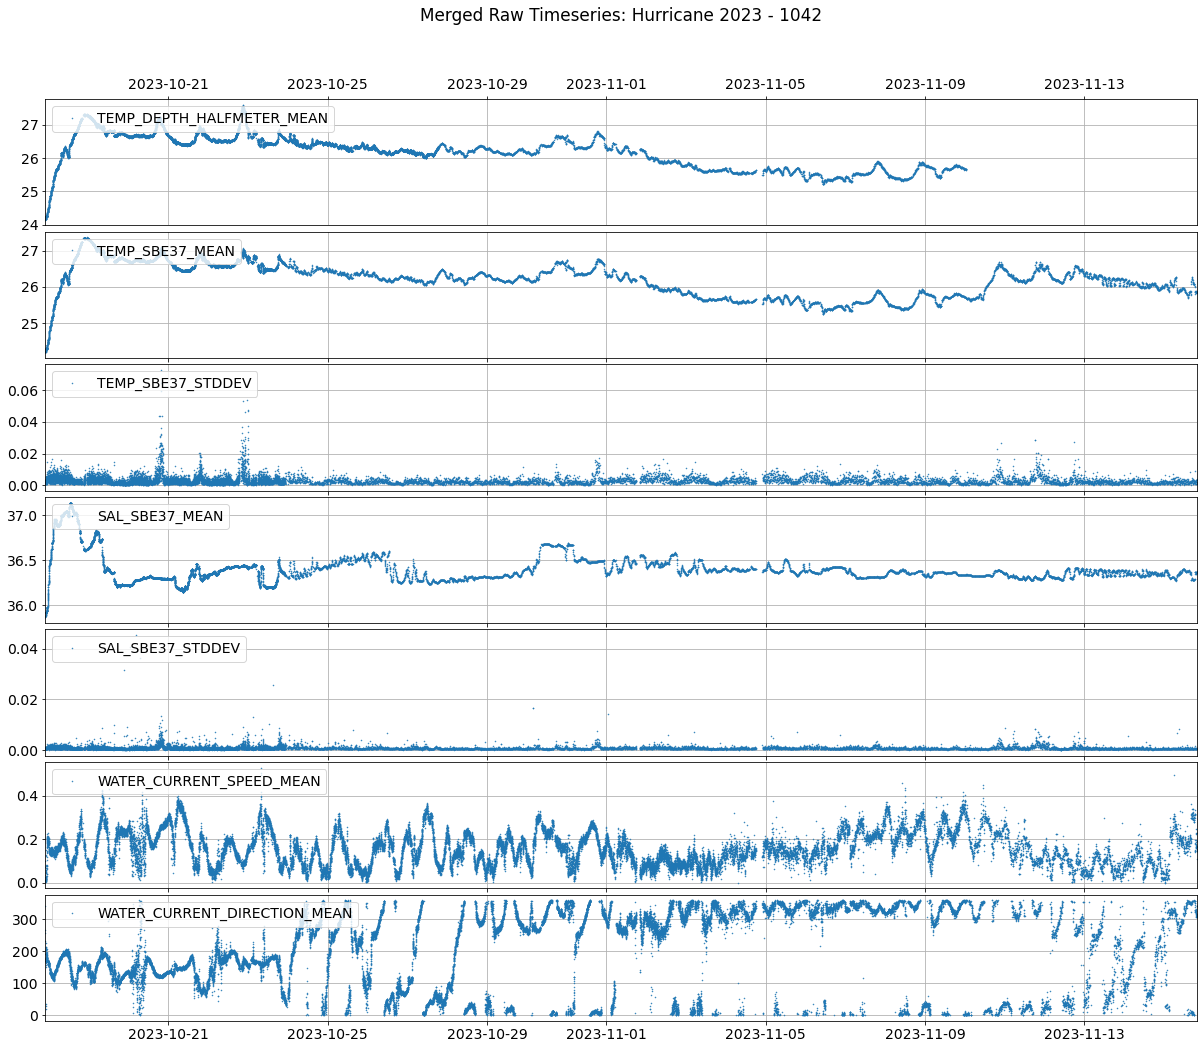

In [20]:
### plot merged raw ocean data (1D data)
print(list(vars_dic.keys()))
vars_plot = ['TEMP_DEPTH_HALFMETER_MEAN','TEMP_SBE37_MEAN','TEMP_SBE37_STDDEV','SAL_SBE37_MEAN','SAL_SBE37_STDDEV',\
             'WATER_CURRENT_SPEED_MEAN','WATER_CURRENT_DIRECTION_MEAN']
nrow = len(vars_plot)
tlim = [dtime[0],dtime[-1]]
### initiate plot
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(20,16)
for i in range( nrow ):
    vkey = vars_plot[i]
    if vkey in vars_dic.keys():
        print(vkey)
        data = vars_dic[vkey]
        h = plt.subplot(nrow,1,i+1)
        plt.plot(dtime,data,'.',ms=1)
        plt.xlim(tlim)
        plt.grid()
        plt.legend(h,labels=[vkey],loc='upper left')
        if i == 0:
            plt.gca().xaxis.set_ticks_position('top')
        elif i < nrow-1:
            plt.gca().set_xticklabels('')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
plt.suptitle('Merged Raw Timeseries: Hurricane '+year+' - '+platf_num)
fig.savefig(pathout+'merge_raw_sea_1D_'+year+'-'+platf_num+'.png', dpi=300,bbox_inches='tight')

In [26]:
### write the merged data to netcdf file: https://unidata.github.io/python-training/workshop/Bonus/netcdf-writing/
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfname_out = 'airsea-raw-merge-'+year+'-SD'+platf_num+'.nc'
ncfile = nc.Dataset(ncfname_out,mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
### creating dimensions
time_dim = ncfile.createDimension('time', len(dtime)) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)
### creating attributes
ncfile.title='Merged files for '+year+' SD-'+platf_num
print(ncfile.title)
ncfile.subtitle="Only selected variables for COARE flux calculations are here. Temporal resolution is 1-minute."
print(ncfile.subtitle)
print(ncfile)
### move the writing data to new variables
### compute the time as seconds since 2022-01-01
time_out = np.array([(dtime[i]-datetime.datetime(int(year),1,1)).total_seconds() for i in range(len(dtime))])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 41280)
Merged files for 2023 SD-1042
Only selected variables for COARE flux calculations are here. Temporal resolution is 1-minute.
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2023 SD-1042
    subtitle: Only selected variables for COARE flux calculations are here. Temporal resolution is 1-minute.
    dimensions(sizes): time(41280)
    variables(dimensions): 
    groups: 


is time_out monotonic? --> True


(array([4.1277e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   60.,  1500.,  2940.,  4380.,  5820.,  7260.,  8700., 10140.,
        11580., 13020., 14460.]),
 <BarContainer object of 10 artists>)

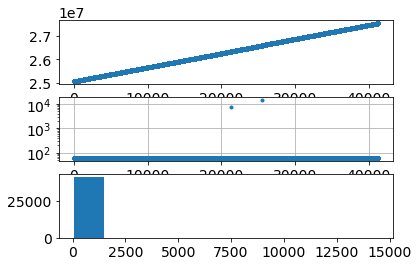

In [27]:
def isMonotonic(A):
    return (all(A[i] <= A[i + 1] for i in range(len(A) - 1)) or
            all(A[i] >= A[i + 1] for i in range(len(A) - 1)))
print('is time_out monotonic? -->', isMonotonic(time_out))

plt.subplot(3,1,1)
plt.plot(time_out,'.')
plt.subplot(3,1,2)
plt.semilogy(np.diff(np.sort(time_out)),'.')
plt.grid()
plt.subplot(3,1,3)
plt.hist(np.diff(np.sort(time_out)))

In [28]:
### Creating variables: 'UWND_MEAN', 'UWND_STDDEV', 'VWND_MEAN', 'VWND_STDDEV', 'GUST_WND_MEAN', 'GUST_WND_STDDEV', 'WIND_MEASUREMENT_HEIGHT_MEAN'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since '+year+'-01-01'
time.long_name = 'time'
### 1D variables
# vars_yes = ['latitude','longitude','UWND_MEAN','UWND_STDDEV','VWND_MEAN','VWND_STDDEV','GUST_WND_MEAN','GUST_WND_STDDEV',\
#             'WIND_MEASUREMENT_HEIGHT_MEAN','TEMP_AIR_MEAN','RH_MEAN','BARO_PRES_MEAN','PAR_AIR_MEAN',\
#                 'WAVE_DOMINANT_PERIOD','WAVE_SIGNIFICANT_HEIGHT',\
#                     'TEMP_DEPTH_HALFMETER_MEAN','TEMP_SBE37_MEAN','TEMP_SBE37_STDDEV','SAL_SBE37_MEAN','SAL_SBE37_STDDEV',\
#                         'WATER_CURRENT_SPEED_MEAN','WATER_CURRENT_DIRECTION_MEAN']
### 1: (time,)
vkey_attr = vars_dic_attr.keys()
for vkey in vars_dic.keys():
    if vkey != 'time':
        ### create variables
        str_exec = vkey + "= ncfile.createVariable('" + vkey + "', np.float64, ('" + 'time' + "',))"
        print(str_exec)
        exec(str_exec)
        # print(i,str_exec)
        vkey_attr_4_this_vkey = [x for x in vkey_attr if vkey in x]
        ### add attributes
        for a in vkey_attr_4_this_vkey:
            ind_ = a.find('-')
            attr_this_round = a[ind_+1:]
            # if attr[a] in attr_in_vkey: # if attribute of this vkey exist, write out
            #     if (attr[a] == 'installed_height') & (vkey in vars_no_installed_height):
            #         pass
            #     else:
            str_exec = vkey + "."+ attr_this_round + " = '"+ str( vars_dic_attr[a] ) + "'"
            exec(str_exec)
            print(a,str_exec)

UWND_MEAN= ncfile.createVariable('UWND_MEAN', np.float64, ('time',))
UWND_MEAN-long_name UWND_MEAN.long_name = 'Eastward wind speed'
UWND_MEAN-units UWND_MEAN.units = 'm s-1'
UWND_MEAN-installed_height UWND_MEAN.installed_height = '5.2'
UWND_STDDEV= ncfile.createVariable('UWND_STDDEV', np.float64, ('time',))
UWND_STDDEV-long_name UWND_STDDEV.long_name = 'Eastward wind speed SD'
UWND_STDDEV-units UWND_STDDEV.units = 'm s-1'
UWND_STDDEV-installed_height UWND_STDDEV.installed_height = '5.2'
VWND_MEAN= ncfile.createVariable('VWND_MEAN', np.float64, ('time',))
VWND_MEAN-long_name VWND_MEAN.long_name = 'Northward wind speed'
VWND_MEAN-units VWND_MEAN.units = 'm s-1'
VWND_MEAN-installed_height VWND_MEAN.installed_height = '5.2'
VWND_STDDEV= ncfile.createVariable('VWND_STDDEV', np.float64, ('time',))
VWND_STDDEV-long_name VWND_STDDEV.long_name = 'Northward wind speed SD'
VWND_STDDEV-units VWND_STDDEV.units = 'm s-1'
VWND_STDDEV-installed_height VWND_STDDEV.installed_height = '5.2'
GUST_WND_MEA

In [29]:
print(vkey_attr_4_this_vkey)

['longitude-long_name', 'longitude-units']


In [30]:
### writing data
# Note: the ":" is necessary in these "write" statements
time[:] = time_out
for vkey in vars_dic.keys():
    if vkey != 'time':
        # str_exec = vars_yes[i] + "[:]= vars_dic['" + vars_yes[i] + "']"
        str_exec = vkey + "[:]= vars_dic['" + vkey + "']"
        exec(str_exec)    
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2023 SD-1042
    subtitle: Only selected variables for COARE flux calculations are here. Temporal resolution is 1-minute.
    dimensions(sizes): time(41280)
    variables(dimensions): float64 time(time), float64 UWND_MEAN(time), float64 UWND_STDDEV(time), float64 VWND_MEAN(time), float64 VWND_STDDEV(time), float64 GUST_WND_MEAN(time), float64 GUST_WND_STDDEV(time), float64 WIND_MEASUREMENT_HEIGHT_MEAN(time), float64 TEMP_AIR_MEAN(time), float64 RH_MEAN(time), float64 BARO_PRES_MEAN(time), float64 PAR_AIR_MEAN(time), float64 WAVE_DOMINANT_PERIOD(time), float64 WAVE_SIGNIFICANT_HEIGHT(time), float64 TEMP_DEPTH_HALFMETER_MEAN(time), float64 TEMP_SBE37_MEAN(time), float64 TEMP_SBE37_STDDEV(time), float64 SAL_SBE37_MEAN(time), float64 SAL_SBE37_STDDEV(time), float64 WATER_CURRENT_SPEED_MEAN(time), float64 WATER_CURRENT_DIRECTION_MEAN(time), float64 latitude(time), float6

In [33]:
vkey_attr = vars_dic_attr.keys()
test = [i for i in vkey_attr if 'UWND_MEAN' in i]
print(test)
ind_ = test[0].find('-')
print(test[0][ind_+1:])

['UWND_MEAN-long_name', 'UWND_MEAN-units', 'UWND_MEAN-installed_height']
long_name
